In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-17 16:05:04.223260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#3qubit-GHZ: Real DATA
def GHZ():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])

In [41]:
def generator(p,w,**kwargs):
    qml.RZ(w[0], wires=3)
    qml.RX(w[1], wires=3)
    qml.RZ(w[2], wires=3)
    qml.RZ(w[3], wires=4)
    qml.RX(w[4], wires=4)
    qml.RZ(w[5], wires=4)
    qml.RZ(w[6], wires=5)
    qml.RX(w[7], wires=5)
    qml.RZ(w[8], wires=5)    
    qml.CZ(wires=[3,4])
    qml.CZ(wires=[4,5])
    qml.CZ(wires=[5,3])
    qml.RZ(w[9], wires=3)
    qml.RX(w[10], wires=3)
    qml.RZ(w[11], wires=3)
    qml.RZ(w[12], wires=4)
    qml.RX(w[13], wires=4)
    qml.RZ(w[14], wires=4)
    qml.RZ(w[15], wires=5)
    qml.RX(w[16], wires=5)
    qml.RZ(w[17], wires=5)
    prob = np.random.rand(3)
    if prob[0] <=p:
        qml.PauliX(wires=3)
    if prob[1] <=p:
        qml.PauliX(wires=4)
    if prob[2] <=p:
        qml.PauliX(wires=5)     

In [39]:
 np.random.rand(0)

tensor([], dtype=float64, requires_grad=True)

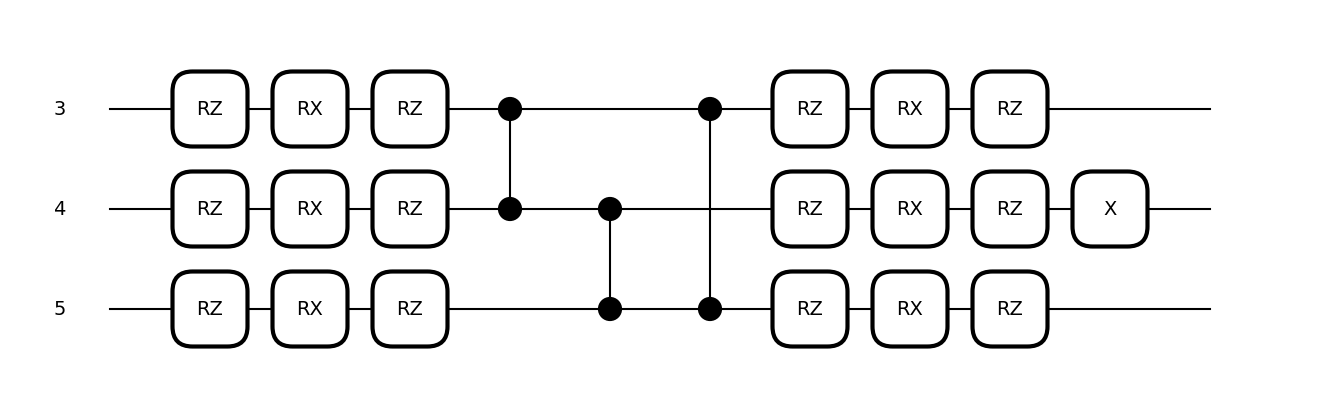

In [42]:
import matplotlib.pyplot as plt
p = 0.1
w = np.array([0]*18)
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(generator)(p,w)
plt.show()

In [43]:
def discriminator(p,w,**kwargs):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[3, 0])
    qml.RZ(w[0], wires=0)
    qml.RZ(w[1], wires=3)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=3)  
    qml.Hadamard(wires=1)
    qml.CZ(wires=[4, 1])
    qml.RZ(w[2], wires=1)
    qml.RZ(w[3], wires=4)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=2)
    qml.CZ(wires=[5, 2])
    qml.RZ(w[4], wires=2)
    qml.RZ(w[5], wires=5)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=5)
    prob = np.random.rand(6)
    if prob[0] <=p:
        qml.PauliX(wires=0)
    if prob[1] <=p:
        qml.PauliX(wires=1)
    if prob[2] <=p:
        qml.PauliX(wires=2)  
    if prob[3] <=p:
        qml.PauliX(wires=3)
    if prob[4] <=p:
        qml.PauliX(wires=4)
    if prob[5] <=p:
        qml.PauliX(wires=5)        

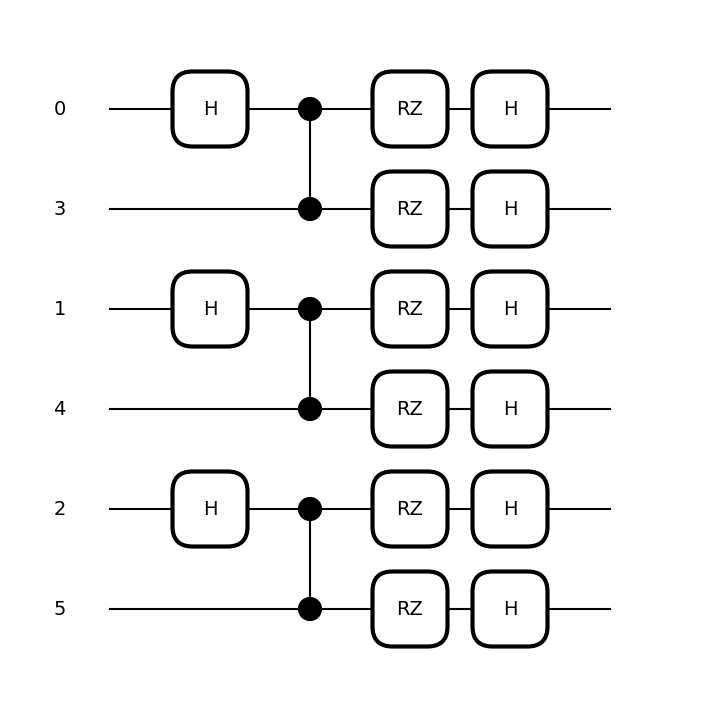

In [44]:
import matplotlib.pyplot as plt
w = np.array([0]*6)
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(discriminator)(p,w)
plt.show()

In [45]:
def state_preparation(name,p):
    if name=='GHZ':
        qml.Hdamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        
    elif name == 'noisy_GHZ_bitflip':
        prob = np.random.rand(0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        if prob[0] <=p:
            qml.PauliX(wires=0)
        if prob[1] <=p:
            qml.PauliX(wires=1)
        if prob[2] <=p:
            qml.PauliX(wires=2)            

In [46]:
n = 3
wires = 2*n
qubits_a = range(0,n)
qubits_b = range(n,wires)

############################################
def swap_readout_op_penny(qubits_a, qubits_b):
    # it is P_0
    """Readout operation for variational swap test.

    Computes the bitwise and of matched qubits from qubits_a and qubits_b.

    Args:
        qubits_a:  The qubits system A act on
        qubits_b: The qubits system B act on
    """

    def _countSetBits(n):
        count = 0
        while n:
            count += n & 1
            n >>= 1
        return count

    def _one_proj(a):
        return (qml.Identity(a)-qml.PauliZ(a))/2

    if len(qubits_a) != len(qubits_b):
        raise ValueError("unequal system sizes.")

    ret_op = qml.Identity(range(0,wires))-qml.Identity(range(0,wires))
    for i in range(1 << len(qubits_a)):
        if _countSetBits(i) % 2 == 0:
            tmp_op = qml.Identity(range(0,wires))
            for j, ch in enumerate(bin(i)[2:].zfill(len(qubits_a))):
                intermediate = _one_proj(qubits_a[j]) @ _one_proj(qubits_b[j])
                if ch == '0':
                    intermediate = qml.Identity(qubits_a[j])@ qml.Identity(qubits_b[j]) - intermediate
                tmp_op = intermediate @ tmp_op
            ret_op = tmp_op + ret_op

    return ret_op

In [47]:
dev = qml.device('default.mixed', wires)

In [50]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit1(gen_weights, disc_weights):
    GHZ()
    generator(p,gen_weights)
    discriminator(p,disc_weights)
    return qml.expval(swap_readout_op_penny(qubits_a, qubits_b))

In [51]:
#Perfect Swap Test
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0]*18)
init_disc_weights = np.array([0]*6)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

In [52]:
real_gen_disc_circuit1(gen_weights, disc_weights)

<tf.Tensor: shape=(), dtype=float64, numpy=0.7499999999999988>